<a href="https://colab.research.google.com/github/crystaljwang/tm10007_group_3/blob/main/main_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# All necessary libraries
All libraries used in this code are run here

In [108]:
# ----- Import necessary libraries -----
from pathlib import Path
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import shapiro 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn import metrics
from sklearn.linear_model import Ridge

# Imports

The code below loads the GIST data from GitHub. This was used once to create the test and train set. It is not needed to run this again

In [20]:
# # Run this to use from colab environment
# !pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

# # Run this to use from colab environment
# !git clone https://github.com/jveenland/tm10007_ml.git

# %cd /content/tm10007_ml/worcgist

ERROR: git+https://github.com/crystaljwang/tm10007_group_3.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [9]:
# # ---- Import data -----
# dir = Path('.') / 'GIST_radiomicFeatures.csv'
# data = pd.read_csv(dir, index_col=0)

# print(f'The number of samples: {len(data.index)}')
# print(f'The number of columns: {len(data.columns)}')

The number of samples: 246
The number of columns: 494


# Splitting the data
This code was used to split the data the first time. To make sure we were all using the same train and test data we wrote csv files for the train and test data, that we are loading again below. This code is used once, and is not necessary to run again.

In [16]:
# # Replace label values from string to binary
# data['label'] = data['label'].replace({'GIST': 1, 'non-GIST': 0})

# # Separate the features and labels
# X = data.drop(['label'], axis=1)
# y = data['label']

# # Split the data into random train and test sets
# X_train_tot, X_test, y_train_tot, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Write the X_test DataFrame to a CSV file
# X_train_tot.to_csv('X_train_tot.csv', index=False)
# X_test.to_csv('X_test.csv', index=False)
# y_train_tot.to_csv('y_train_tot.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)

fatal: destination path 'tm10007_group_3' already exists and is not an empty directory.
[Errno 2] No such file or directory: '/content/tm10007_group_3'
/content/tm10007_ml/worcgist
/content/tm10007_ml/worcgist


# Load the train data

In [132]:
#load split data from our repository
url = "https://raw.githubusercontent.com/crystaljwang/tm10007_group_3/main/data/"
X_train_tot = pd.read_csv(url + 'X_train_tot.csv')
y_train_tot = pd.read_csv(url + 'y_train_tot.csv')
X_test = pd.read_csv(url + 'X_test.csv')
y_test = pd.read_csv(url + 'y_test.csv')

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_tot, y_train_tot, test_size=0.15, random_state=42)

# Exploring the data

In [133]:
# Percentage GIST vs Non-GIST
counts = y_train.value_counts(normalize=True)
percentage_nongist = counts[0] * 100
percentage_gist = counts[1] * 100

print(f'Percentage of non-GIST in training set: {percentage_nongist:.2f}%')
print(f'Percentage of GIST in training set: {percentage_gist:.2f}%')

# Check for missing data
if X_train.isnull().sum().sum() > 0:
    print('Missing data found.')
    exit()
else:
    print('No missing data found.')

# Check for categorial values
categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
if len(categorical_cols) > 0:
    print(f'Categorical columns found: {categorical_cols}')
    exit()
else:
    print('No categorical columns found.')

# Perform Shapiro-Wilk test for normality
p_values_above_threshold = []
for col in X_train.columns:
  stat, p = shapiro((X_train))
  p_values_above_threshold.append(p > 0.05)
  #print(f'Shapiro test for column {col}: statistic = {stat:.3f}, p-value = {p:.3f}')

percent_above_threshold = sum(p_values_above_threshold) / len(p_values_above_threshold) * 100
print(f'{percent_above_threshold:.1f} percent of the data is normally distributed.')

#print('stat=%.3f, p=%.3f\n' % (stat, p))

Percentage of non-GIST in training set: 51.20%
Percentage of GIST in training set: 48.80%
No missing data found.
No categorical columns found.


/usr/local/lib/python3.9/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


0.0 percent of the data is normally distributed.


# Preprocessing

In [134]:
# ----- Outliers -----

def replace_outliers(X_train, X_val, X_test):
    """
    Replaces the outliers in a DataFrame with the lower or upper bound.

    :param data: The DataFrame to be filtered
    :return: A new DataFrame with the outliers replaced by the lower or upper bound for each column
    """
    # Calculate the lower and upper bounds based on each column's median and interquartile range
    # based on train data
    Q1 = X_train.quantile(0.25)
    Q3 = X_train.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Replace the outliers with the lower or upper bound 
    # in train, validation and test data from train data fit
    for col in X_train.columns:
        X_train[col] = X_train[col].apply(lambda x: upper_bound[col] if x > upper_bound[col] else x)
        X_train[col] = X_train[col].apply(lambda x: lower_bound[col] if x < lower_bound[col] else x)
        X_val[col] = X_val[col].apply(lambda x: upper_bound[col] if x > upper_bound[col] else x)
        X_val[col] = X_val[col].apply(lambda x: lower_bound[col] if x < lower_bound[col] else x)        
        X_test[col] = X_test[col].apply(lambda x: upper_bound[col] if x > upper_bound[col] else x)
        X_test[col] = X_test[col].apply(lambda x: lower_bound[col] if x < lower_bound[col] else x)
  
    return X_train, X_val, X_test

# Replace the outliers in each column with the lower or upper bound
X_train, X_val, X_test = replace_outliers(X_train, X_val, X_test)



In [135]:
# ----- Data Scaling -----
scaler = MinMaxScaler()  # define scaler

X_train = scaler.fit_transform(X_train)  # fit scaler on train set
X_val = scaler.transform(X_val)  # apply fitted scaler on validation set
X_test = scaler.transform(X_test)  # apply fitted scaler on test set

In [136]:
# ----- Remove zero-variance features -----
X_train = pd.DataFrame(X_train)
zero_var_filter = VarianceThreshold(threshold=0)

# Fit on train data
zero_var_filter.fit(X_train)
zero_var_columns = [column for column in X_train.columns if column not in X_train.columns[zero_var_filter.get_support()]]

# Apply on train, validation and test data
X_train = zero_var_filter.transform(X_train)
X_val = zero_var_filter.transform(X_val)
X_test = zero_var_filter.transform(X_test)

In [137]:
# ----- Feature selection -----
lasso_selector = SelectFromModel(estimator=Lasso(alpha=10**(-10), max_iter=1000), threshold='median')
lasso_selector.fit(X_train, y_train)
lasso_list = [column for column in pd.DataFrame(X_train).columns[lasso_selector.get_support()]]
n_original = X_train.shape[1]

#Apply fitted feature selection on train, validation and test set
X_train = lasso_selector.transform(X_train)
X_val = lasso_selector.transform(X_val)
X_test = lasso_selector.transform(X_test)

#Print selected featues
n_selected = X_train.shape[1]
print(f"Selected {n_selected} from {n_original} features.")

Selected 228 from 455 features.


In [138]:
# ----- Feature extraction -----
from sklearn.decomposition import PCA

# 95% variance
pca = PCA(n_components = 0.95)
pca.fit(X_train) #fit PCA on train set

#Apply fitted PCA feature extraction on train, validation and test set
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)
X_test = pca.transform(X_test)

print(f"Selected {X_train.shape[1]} features to be used for classification.")

Selected 50 features to be used for classification.


# Classifier
Now the features are selected, we are testing the different classifiers.

In [144]:
def learning_curve(X_train, y_train, model):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 6))

  common_params = {
      "X": X_train,
      "y": y_train,
      "train_sizes": np.linspace(0.1, 1.0, 5),
      "cv": ShuffleSplit(n_splits=5, test_size=0.15, random_state=0),
      "score_type": "both",
      "n_jobs": 4,
      "line_kw": {"marker": "o"},
      "std_display_style": "fill_between",
      "score_name": "Accuracy",
  }

  LearningCurveDisplay.from_estimator(model, **common_params, ax=ax)
  handles, label = ax.get_legend_handles_labels()
  ax.legend(handles[:2], ["Training Score", "Test Score"])
  ax.set_title(f"Learning Curve for {model.__class__.__name__}")
  plt.show()

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


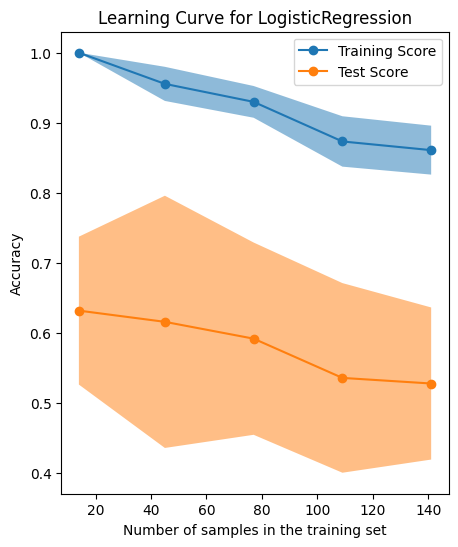

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


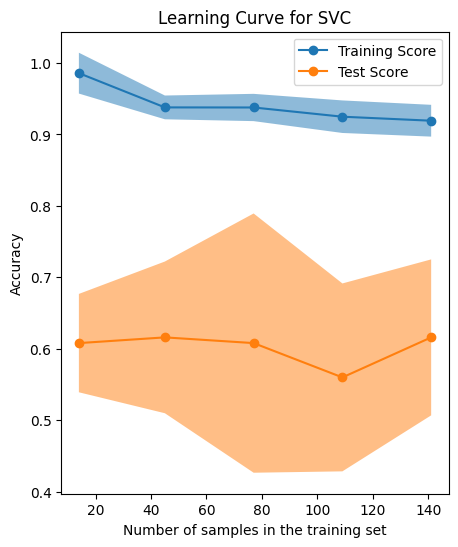

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


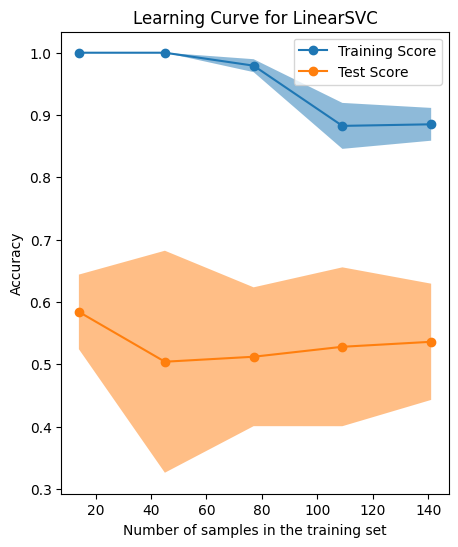

/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


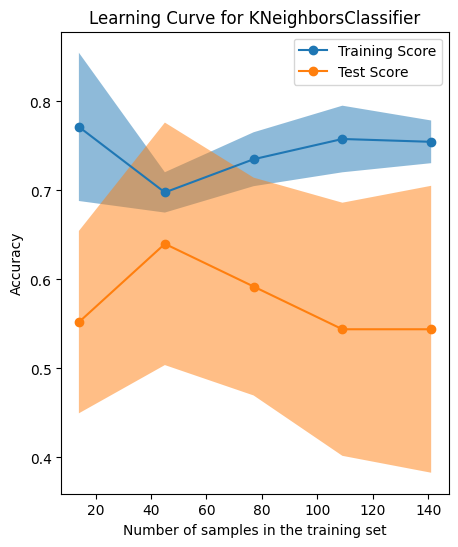

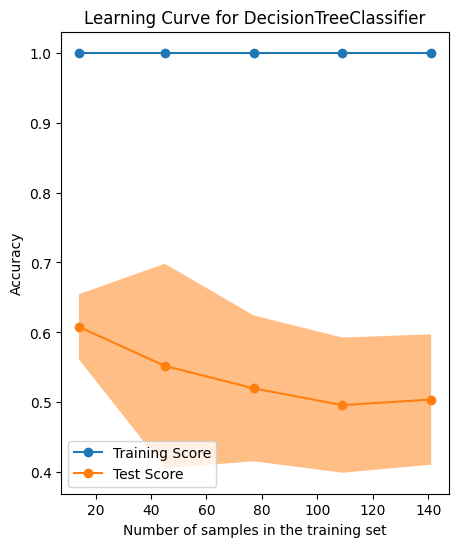

<ipython-input-160-a6f186889a31>:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  fit_model.append(model.fit(X_train, y_train))


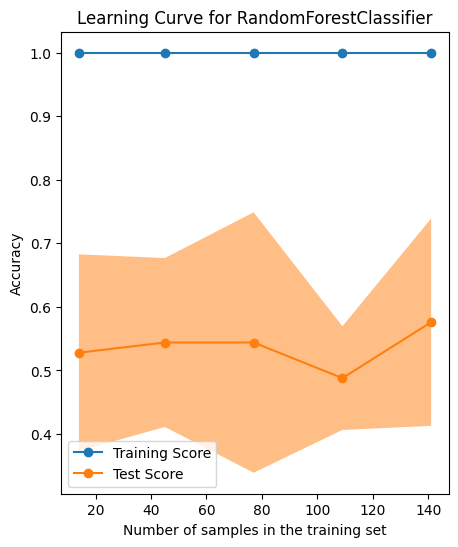

/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


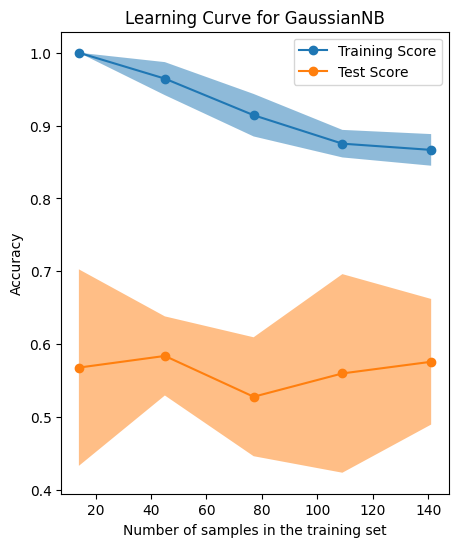

,Model,Accuracy,AUC
0,LogisticRegression,0.533333,0.53
1,SVC,0.500000,0.50
2,Linear SVC,0.666667,0.67
3,KNN,0.600000,0.60
4,Decision Tree,0.633333,0.63
5,Random Forest,0.500000,0.50
6,Naive Bayes,0.666667,0.67


In [160]:
##CLASSIFIERS

# Prepare pipeline
model_pipeline = []
model_pipeline.append(LogisticRegression(max_iter = 1000))
model_pipeline.append(SVC())
model_pipeline.append(LinearSVC())
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())

model_list = ['LogisticRegression', 'SVC', 'Linear SVC', 'KNN', 'Decision Tree', 'Random Forest', 'Naive Bayes']
acc_list = []
auc_list = []
cm_list = []
fit_model = []

# Execute pipeline
for model in model_pipeline:
  fit_model.append(model.fit(X_train, y_train))
  y_pred = model.predict(X_val)
  acc_list.append(metrics.accuracy_score(y_val, y_pred))
  fpr, tpr, _thresholds = metrics.roc_curve(y_val, y_pred)
  auc_list.append(round(metrics.auc(fpr, tpr),2))
  cm_list.append(confusion_matrix(y_val, y_pred))
  learning_curve(X_train, y_train, model)

##VALIDATION
# Plot Model validation
result_df = pd.DataFrame({'Model':model_list, 'Accuracy': acc_list, 'AUC': auc_list})
result_df

In [95]:
# ----- TEST SET ------

# Prepare pipeline
acc_list = []
auc_list = []
cm_list = []

# Execute pipeline
for model in fit_model:
  y_pred = model.predict(X_test)
  acc_list.append(metrics.accuracy_score(y_test, y_pred))
  fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred)
  auc_list.append(round(metrics.auc(fpr, tpr),2))
  cm_list.append(confusion_matrix(y_test, y_pred))

##VALIDATION
# Plot Model validation
result_df = pd.DataFrame({'Model':model_list, 'Accuracy': acc_list, 'AUC': auc_list})
result_df

,Model,Accuracy,AUC
0,LogisticRegression,0.58,0.59
1,SVC,0.62,0.64
2,Linear SVC,0.58,0.59
3,KNN,0.58,0.59
4,Decision Tree,0.56,0.58
5,Random Forest,0.60,0.60
6,Naive Bayes,0.54,0.55


In [159]:
##Hyperparameters KNN classifier
import numpy as np
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn import svm

# search = GridSearchCV(
#     estimator = KNeighborsClassifier(),
#     param_grid = {'n_neighbors': list(range(1,51,2)), 
#                   'weights': ['uniform', 'distance'],
#                   'metric': ['euclidean', 'manhattan', 'minkowski']},
#     scoring="roc_auc",
#     cv=5,
#     verbose=3,
#     n_jobs=-1)

search = RandomizedSearchCV(
          KNeighborsClassifier(),
          {'n_neighbors': list(range(1,50,1)), 
                  'weights': ['uniform', 'distance'],
                  'metric': ['euclidean', 'manhattan', 'minkowski']},
          n_iter=500, scoring='accuracy', n_jobs=-1, cv=3, random_state=1)

# execute search
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

#validate
y_pred = search.predict(X_val)
acc = (metrics.accuracy_score(y_val, y_pred))
fpr, tpr, _thresholds = metrics.roc_curve(y_val, y_pred)
auc = (round(metrics.auc(fpr, tpr),2))

print(auc)
print(acc)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 294 is smaller than n_iter=500. Running 294 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Score: 0.7048701298701299
Best Hyperparameters: {'weights': 'distance', 'n_neighbors': 30, 'metric': 'manhattan'}
0.5
0.5


/usr/local/lib/python3.9/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
